In [51]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.stats import LombScargle
import astropy.units as u                          # We'll need this later.

from astropy.io import ascii
import glob, re, copy
from hot_utils import *

from lightkurve import KeplerLightCurveFile, KeplerLightCurve

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


### Load a cool Kepler object - an oscillating star with a putative planet as found by [Sowicka et al](http://adsabs.harvard.edu/abs/2017MNRAS.467.4663S), 2017.

In [2]:
lcs = KeplerLightCurveFile.from_archive(8197761,quarter='all',cadence='long')

lc = stitch_lc_list(lcs)

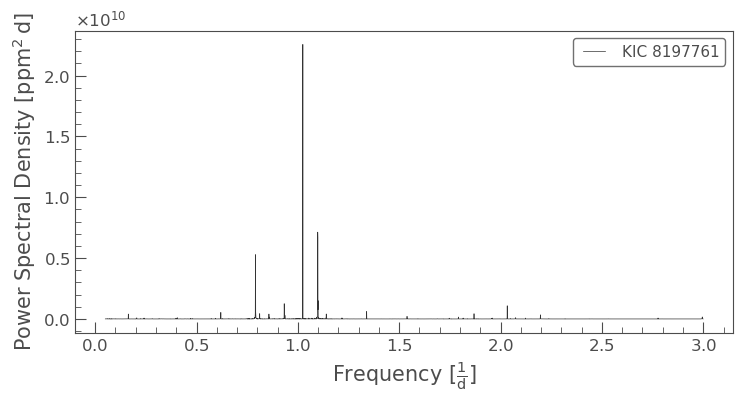

In [3]:
pg = lc.to_periodogram(min_period=8./24.*u.day, max_period=20.*u.day)
pg.plot();


### Test the iterative sine fitting

In [4]:
dummy = copy.copy(lc)



In [5]:
dummy.flux = 1.+np.sin(dummy.time/2.)

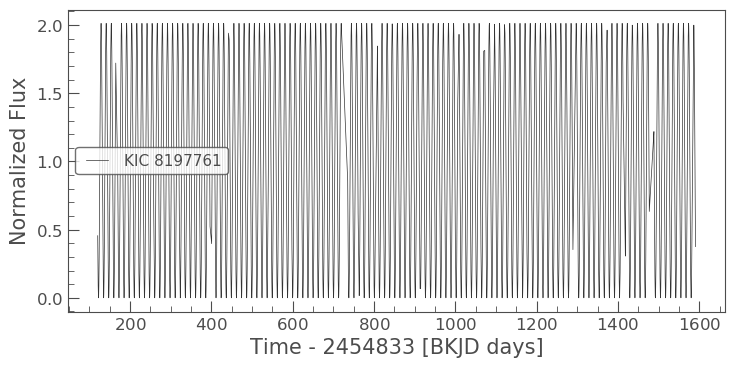

In [6]:
dummy.plot()

In [7]:
frequency, power = LombScargle(dummy.time, dummy.flux, dummy.flux_err).autopower(minimum_frequency=0.01,maximum_frequency=1.9,
...                                                    samples_per_peak=10)

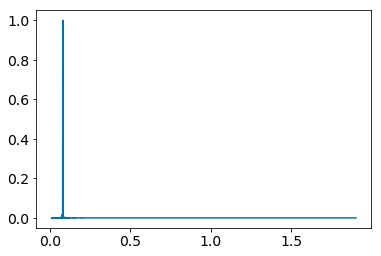

In [8]:
plt.plot(frequency,power)

12.5663989051 d


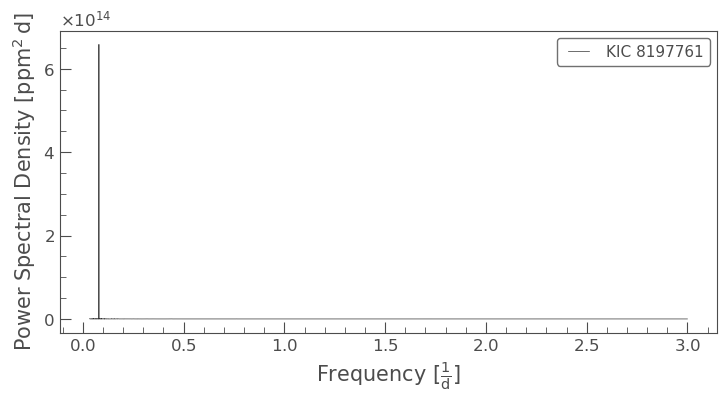

In [9]:
pg = dummy.to_periodogram(min_period=8./24.*u.day, max_period=30.*u.day)
pg.plot();
print 1/pg.frequency_at_max_power


In [10]:
toy, ff, pp, noise = iterative_sine_fit(dummy, 1, min_period=8./24., max_period=30.)    
print (1./ff[0]/2./np.pi)

1.9999891592330614


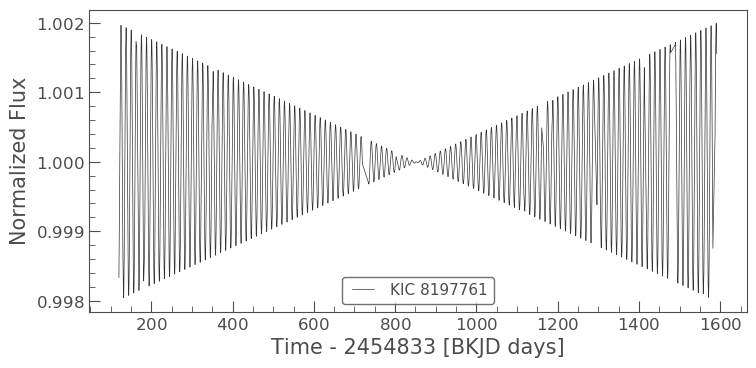

In [11]:
toy.plot()

### Can we renormalize a light curve using the sine signal?

In [12]:
dummy = copy.copy(lc)

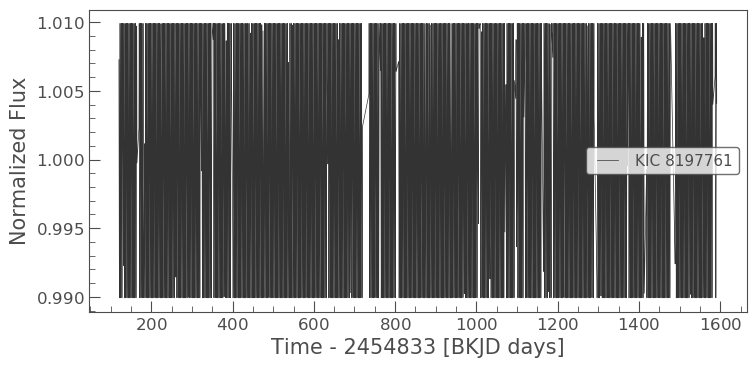

In [13]:
dummy.flux = 1.+0.01*np.sin(dummy.time*2)
dummy.plot()

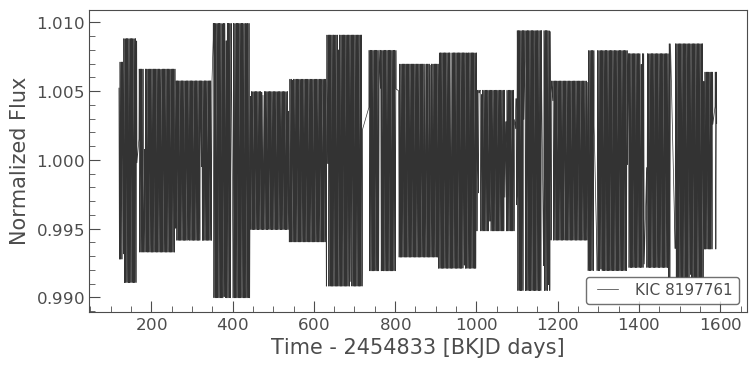

In [14]:
coeffs = 0.5+0.5*np.random.rand(len(np.unique(dummy.quarter)))
for j, q in enumerate(np.unique(dummy.quarter)):
    m = (dummy.quarter == q)
    dummy.flux[m] = 1.+(dummy.flux[m]-1.)*coeffs[j]
dummy.plot()

In [15]:
dummy2, powers = sine_renormalize(dummy, min_period=0.5,max_period=10)


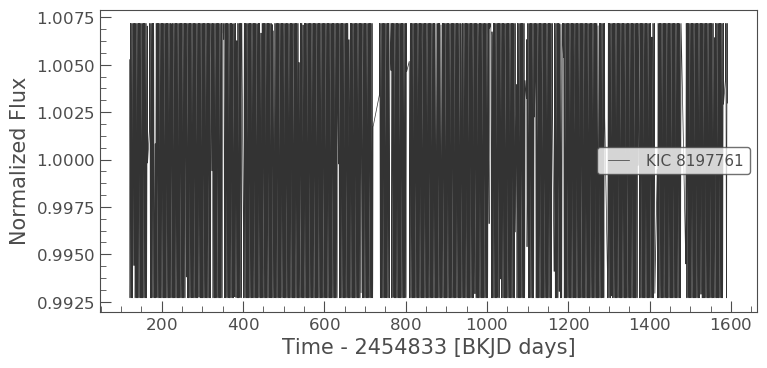

In [16]:
dummy2.plot()

### Run an iterative sine-fitting algorithm to subtract out the stellar signal

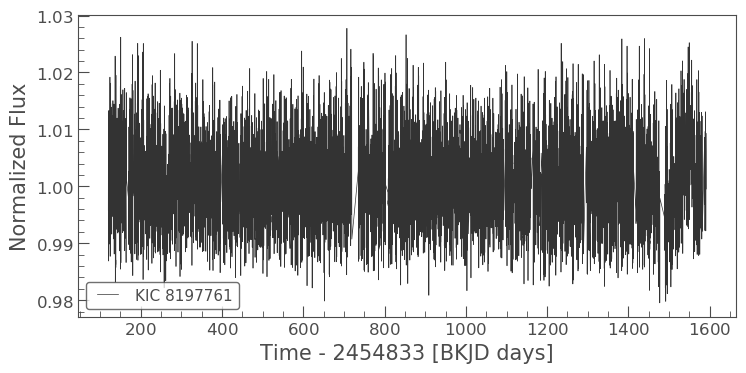

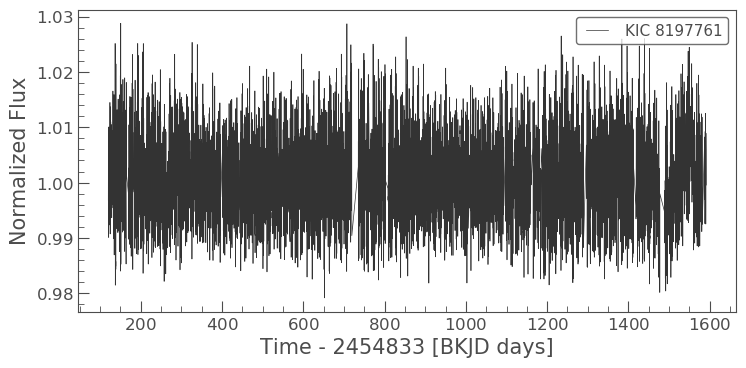

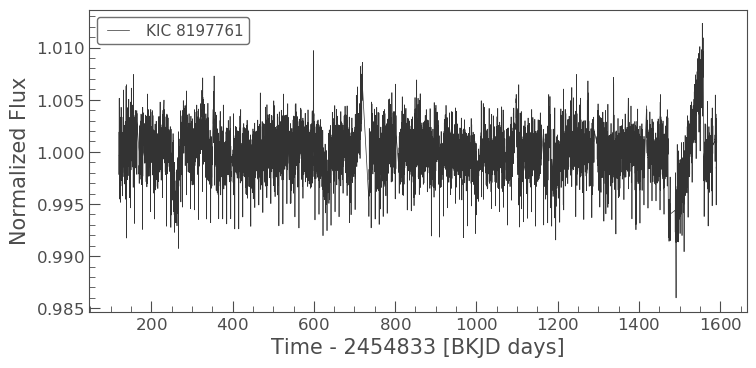

In [17]:
lc.plot()

lc2, powers = sine_renormalize(lc,min_period=4./24., max_period=30.)

lc2.plot()

lc3, ff, pp, noise = iterative_sine_fit(lc2, 60)    

lc3.plot()

In [18]:
print lc3.cdpp()

833.6209512905983


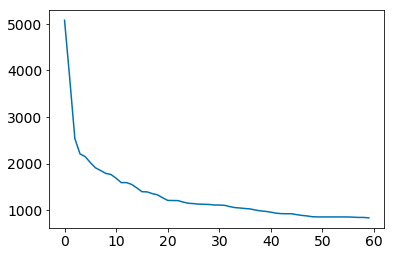

In [19]:
plt.plot(noise)

In [20]:
for q in range(18):
    m = (lc.quarter==q)
#     plt.plot(lc.time[m],lc.flux[m],'.')
#     plt.plot(lc.time[m],lc2.flux[m],'-')

    

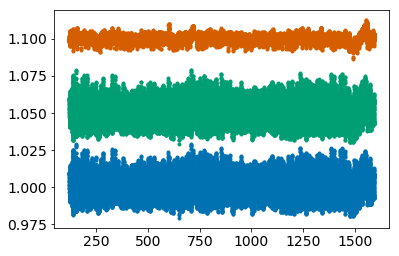

In [21]:
# lc2=lc2.flatten()
plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,lc2.flux+0.05,'.')
plt.plot(lc.time,lc3.flux+0.1,'.')

# plt.xlim(500,900)

### What does the raw light curve look like on a planet?

In [22]:
planet_period = 9.8686667
folded = lc.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

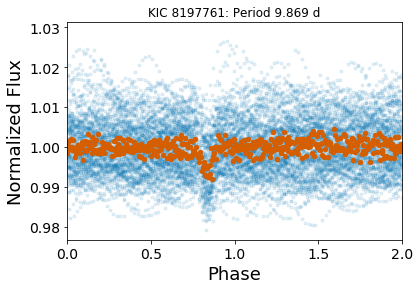

In [23]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')

### And now after sine fitting

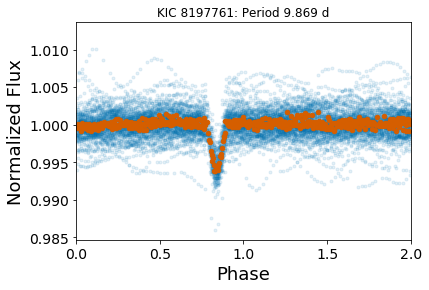

In [24]:
planet_period = 9.8686667
folded = lc3.fold(planet_period)
binned = folded.bin(binsize=25,method='median')

plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')

### Now use the Oxford systematics correction

In [25]:
lc4 = copy.deepcopy(lc3)

for qq in np.unique(lc4.quarter.astype('int')):
#     print qq
    m = lc4.quarter==qq
    lc4.flux[m] = correct_quarter(lc4,qq)
    
print 'Done'

Done


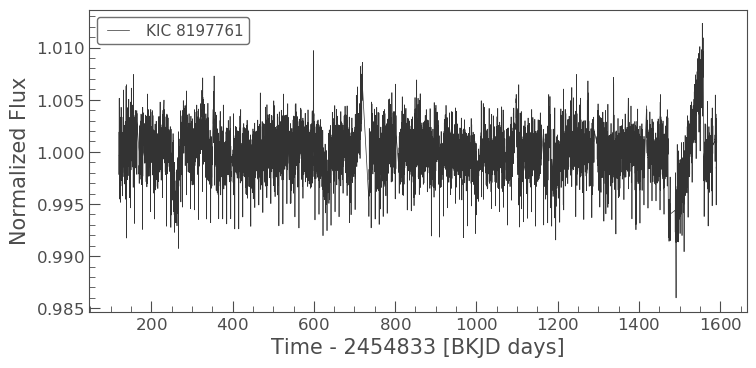

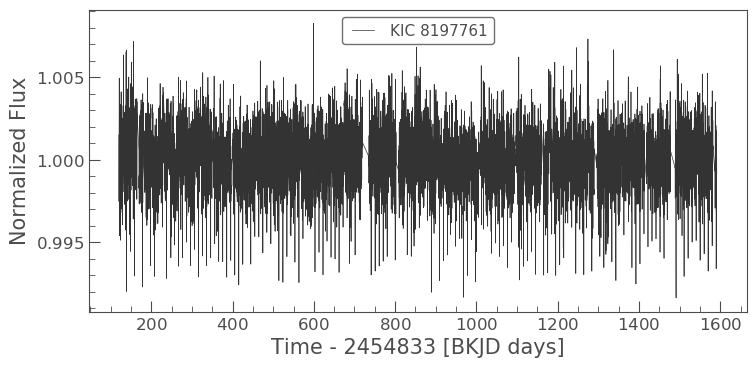

In [26]:
lc3.plot()
lc4.plot()

In [27]:
print "It doesn't affect the CDPP much but helps the long term trends"
print lc3.estimate_cdpp()
print lc4.estimate_cdpp()

It doesn't affect the CDPP much but helps the long term trends
833.6209512905983
833.2579387193189


### How well do we do at subtracting the sine waves?

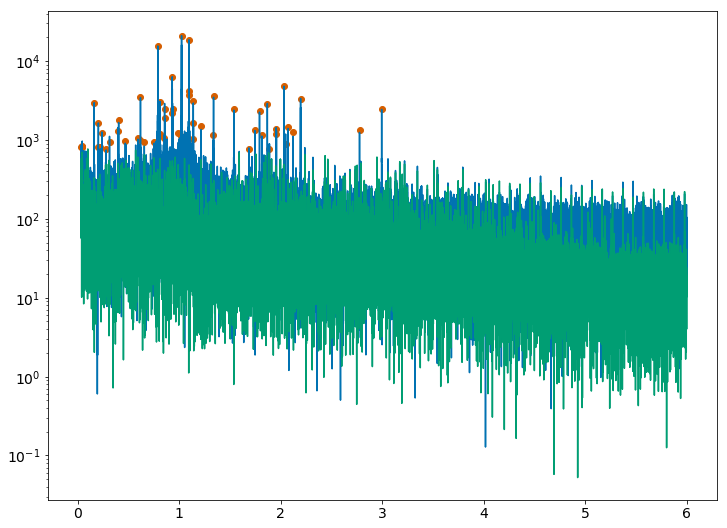

In [53]:
frequency, power = LombScargle(lc2.time, lc2.flux, lc2.flux_err).autopower(minimum_frequency=1./(30.),maximum_frequency=1./(4./24),
...                                                    samples_per_peak=10,normalization='psd')
plt.plot(frequency,power**0.5)
plt.yscale('log')

plt.scatter(ff,pp**0.5,color=colours[2])
frequency2, power2 = LombScargle(lc4.time, lc4.flux, lc4.flux_err).autopower(minimum_frequency=1./(30.),maximum_frequency=1./(4./24),
...                                                    samples_per_peak=10,normalization='psd')
plt.plot(frequency2,power2**0.5)


## Now do a BLS search to find the planet

In [28]:
from pybls import BLS


In [29]:
bls = BLS(lc4.time, lc4.flux, lc4.flux_err/10., period_range=(1,40), q_range=(0.001, 0.01), nf=4500, nbin=2000)


In [30]:
res = bls()

In [31]:
bper = bls.period[np.argmax(bls.sde-renorm_sde(bls))]

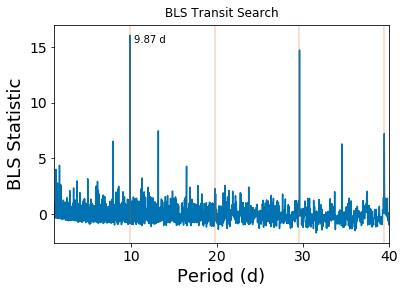

In [32]:
plt.plot(bls.period,bls.sde-renorm_sde(bls))
for j in range(np.round(bls.period.max()/bper).astype('int')):
    plt.axvline(bper*(j+1),alpha=0.25,color=colours[2])
plt.text(bper*1.05,bls.sde.max()*0.95,'%.2f d' % bper)
plt.xlim(bls.period.min(),bls.period.max())
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)
plt.savefig('bls_%d.png' %  lc.targetid)

### Now refine it

In [33]:
bls = BLS(lc4.time, lc4.flux, lc4.flux_err, period_range=(bper*0.98,bper*1.02), q_range=(0.001, 0.01), nf=4500, nbin=2000)
res = bls()
bper = bls.period[np.argmax(bls.sde-renorm_sde(bls))]

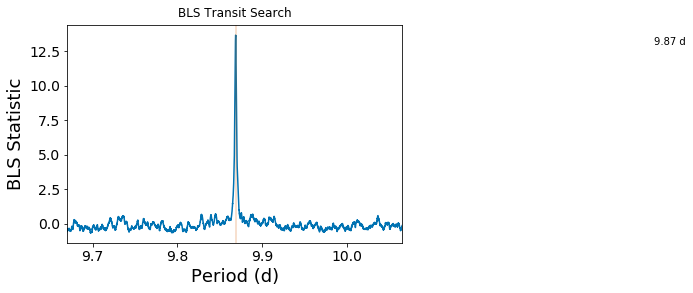

In [34]:
plt.plot(bls.period,bls.sde)
for j in range(np.round(bls.period.max()/res.bper).astype('int')):
    plt.axvline(bper*(j+1),alpha=0.25,color=colours[2])
plt.text(bper*1.05,bls.sde.max()*0.95,'%.2f d' % res.bper)
plt.xlim(bls.period.min(),bls.period.max())
plt.xlabel('Period (d)')
plt.ylabel('BLS Statistic')
plt.title('BLS Transit Search',y=1.01)
plt.savefig('bls_%d.png' %  lc.targetid)

### Plot the folded light curve

In [35]:
planet_period = 9.8686667 # literature
planet_period = bper
folded = lc4.fold(planet_period)
binned = folded.bin(binsize=25,method='mean')

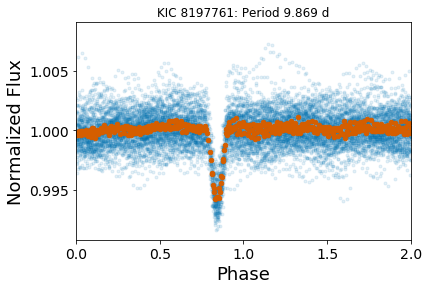

In [36]:
plt.plot(folded.phase*planet_period,folded.flux,'.',alpha=0.1)
plt.plot(binned.phase*planet_period,binned.flux,'.',markersize=9,color=colours[2])
plt.xlim(0,2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('KIC %d: Period %.3f d' % (lc.targetid,planet_period))
plt.savefig('oscillator_with_planets.png')